# Imports And Setup

In [10]:
import pickle
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
import joblib
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [11]:
# Data file names
batch1_name = "CIFAR_data/data_batch_1"
batch2_name = "CIFAR_data/data_batch_2"
batch3_name = "CIFAR_data/data_batch_3"
batch4_name = "CIFAR_data/data_batch_4"
batch5_name = "CIFAR_data/data_batch_5"
batchT_name = "CIFAR_data/test_batch"
meta_name = "CIFAR_data/batches.meta"

# Data Loading And Cleaning

In [12]:
# Used to load in the data files
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [13]:
# Load in each data file
batch1 = unpickle(batch1_name)
batch2 = unpickle(batch2_name)
batch3 = unpickle(batch3_name)
batch4 = unpickle(batch4_name)
batch5 = unpickle(batch5_name)
batchT = unpickle(batchT_name)

In [14]:
# What does the data look like?
print(batch1.keys())             # Keys
print(batch1[b'batch_label'])    # Batch label
print(batch1[b'labels'][:10])    # Labels
print(type(batch1[b'labels']))   # Label type
print(batch1[b'data'][0])        # Data
print(type(batch1[b'data']))   # Data type
print(batch1[b'filenames'][:10]) # Filenames

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
b'training batch 1 of 5'
[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]
<class 'list'>
[ 59  43  50 ... 140  84  72]
<class 'numpy.ndarray'>
[b'leptodactylus_pentadactylus_s_000004.png', b'camion_s_000148.png', b'tipper_truck_s_001250.png', b'american_elk_s_001521.png', b'station_wagon_s_000293.png', b'coupe_s_001735.png', b'cassowary_s_001300.png', b'cow_pony_s_001168.png', b'sea_boat_s_001584.png', b'tabby_s_001355.png']


In [15]:
# Store the labels and data as a numpy array
batch1['labels'] = np.array(batch1[b'labels'], dtype=np.int8)
batch1['data'] = batch1[b'data']
batch2['labels'] = np.array(batch2[b'labels'], dtype=np.int8)
batch2['data'] = batch2[b'data']
batch3['labels'] = np.array(batch3[b'labels'], dtype=np.int8)
batch3['data'] = batch3[b'data']
batch4['labels'] = np.array(batch4[b'labels'], dtype=np.int8)
batch4['data'] = batch4[b'data']
batch5['labels'] = np.array(batch5[b'labels'], dtype=np.int8)
batch5['data'] = batch5[b'data']
batchT['labels'] = np.array(batchT[b'labels'], dtype=np.int8)
batchT['data'] = batchT[b'data']

In [16]:
# Check if the conversion was successful
print(batch1['labels'][:10])
print(batch1['data'][0])

[6 9 9 4 1 1 2 7 8 3]
[ 59  43  50 ... 140  84  72]


In [17]:
# Load in the metadata
meta = unpickle(meta_name)

In [18]:
# Visualize the metadata
meta[b'label_names']

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

In [19]:
# Convert the metadata to dictionaries
meta_numToLab = {i:str(meta[b'label_names'][i])[2:-1] for i in range(0, len(meta[b'label_names']))}
meta_labToNum = {str(meta[b'label_names'][i])[2:-1]:i for i in range(0, len(meta[b'label_names']))}

In [20]:
meta_numToLab

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [21]:
meta_labToNum

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [22]:
# Combine the data into a single array of labels and an array of data
# and store the data in a dnew dictionary
batchC = {"train":dict(), "test":dict(), "all":dict()}
batchC["train"]["y"] = np.concatenate((batch1["labels"], batch2["labels"], batch3["labels"], batch4["labels"], batch5["labels"]), dtype=np.int8)
batchC["train"]["X"] = np.concatenate((batch1["data"], batch2["data"], batch3["data"], batch4["data"], batch5["data"]), dtype=np.uint8)
batchC["test"]["y"] = np.array(batchT["labels"], dtype=np.int8)
batchC["test"]["X"] = np.array(batchT["data"], dtype=np.uint8)
batchC["all"]["X"] = np.concatenate((batchC["train"]["X"], batchC["test"]["X"]))
batchC["all"]["y"] = np.concatenate((batchC["train"]["y"], batchC["test"]["y"]))

In [23]:
# Ensure the conversion was successful
assert np.array_equal(batchC["train"]["y"][:10], batch1["labels"][:10])
assert np.array_equal(batchC["train"]["y"][-10:], batch5["labels"][-10:])
assert np.array_equal(batchC["train"]["X"][:10], batch1["data"][:10])
assert np.array_equal(batchC["train"]["X"][-10:], batch5["data"][-10:])

assert np.array_equal(batchC["test"]["y"][:10], batchT["labels"][:10])
assert np.array_equal(batchC["test"]["y"][-10:], batchT["labels"][-10:])
assert np.array_equal(batchC["test"]["X"][:10], batchT["data"][:10])
assert np.array_equal(batchC["test"]["X"][-10:], batchT["data"][-10:])

assert batchC["train"]["X"].shape[0] + batchC["test"]["X"].shape[0] == batchC["all"]["X"].shape[0]
assert batchC["train"]["y"].shape[0] + batchC["test"]["y"].shape[0] == batchC["all"]["y"].shape[0]

In [24]:
# The data shapes
print(f'Train Labels: {batchC["train"]["y"].shape}')
print(f'Train Data:   {batchC["train"]["X"].shape}')
print(f'Test Labels:  {batchC["test"]["y"].shape}')
print(f'Test Data:    {batchC["test"]["X"].shape}')
print(f'All Labels:   {batchC["all"]["y"].shape}')
print(f'All Data:     {batchC["all"]["X"].shape}')

Train Labels: (50000,)
Train Data:   (50000, 3072)
Test Labels:  (10000,)
Test Data:    (10000, 3072)
All Labels:   (60000,)
All Data:     (60000, 3072)


# SGDClassifier

In [45]:
# Create the classgdcsifier
sgdc = SGDClassifier(max_iter=1000)

In [63]:
# Load a pretrained model
#sgdc = joblib.load("models/sgdc.pkl")

# or train the classifier
sgdc.fit(batchC["train"]["X"], batchC["train"]["y"])

SGDClassifier()

In [36]:
# Check the train and test accuracy
print(f'Train: {sgdc.score(batchC["train"]["X"], batchC["train"]["y"])}')
print(f'Test: {sgdc.score(batchC["test"]["X"], batchC["test"]["y"])}')

Train: 0.27238
Test: 0.2294


In [37]:
# Get a report for the classification model
preds = sgdc.predict(batchC["train"]["X"])
print(classification_report(batchC["train"]["y"], preds))

              precision    recall  f1-score   support

           0       0.48      0.11      0.18      5000
           1       0.84      0.08      0.14      5000
           2       0.66      0.02      0.04      5000
           3       0.25      0.46      0.33      5000
           4       0.53      0.05      0.08      5000
           5       0.49      0.05      0.09      5000
           6       0.66      0.13      0.21      5000
           7       0.25      0.63      0.36      5000
           8       0.20      0.94      0.34      5000
           9       0.64      0.27      0.38      5000

    accuracy                           0.27     50000
   macro avg       0.50      0.27      0.22     50000
weighted avg       0.50      0.27      0.22     50000



In [34]:
# Save the model
joblib.dump(sgdc, "models/sgdc.pkl") 

['models/sgdc.pkl']

### Notes
- This classifier seemed to do pretty bad on both the train and test sets
- The training takes forver due to it being an iterative process
- The prediction is quick due to it being a simple function

#### Pros:
- The model makes a quick prediction
- The model decently generalizes

#### Cons:
- The model takes a really long time to train
- The accuracy is pretty average compared to the rest of the models tested, but it's still low

# Linear Regression

In [21]:
# Create the model
LR = sk.linear_model.LinearRegression()

In [22]:
# Load a pretrained model
#LR = joblib.load("models/LR.pkl")

# Or fit the model
LR.fit(batchC["train"]["X"], batchC["train"]["y"])

LinearRegression()

In [23]:
# Check the train and test accuracy
print(f'Train: {LR.score(batchC["train"]["X"], batchC["train"]["y"])}')
print(f'Test: {LR.score(batchC["test"]["X"], batchC["test"]["y"])}')

Train: 0.1502478112317177
Test: 0.026348067178683765


In [24]:
# Save the model
joblib.dump(LR, "models/LR.pkl") 

['models/LR.pkl']

### Notes
- This classifier seemed to give terrible predictions.
- The training is pretty quick due to the number of parameters being low.
- The model is very quick to make predictions on all the data.
- Since the model has very few parameters, it will underfit any data that isn't linear, but it will make a quick prediction and it will train quickly.

#### Pros:
- The model takes little time to train
- The model makes a quick prediction

#### Cons:
- The model has very low accuracy when making predictions
- The model looks to overfit on the training data since the test accuracy is really far from the train accuracy

# Decision Tree Regressor

In [41]:
# Create the models
DCR1 = DecisionTreeRegressor(max_depth=3)
DCR2 = DecisionTreeRegressor(max_depth=5)

In [20]:
# Load pretrained models
#DCR1 = joblib.load("models/DCR1.pkl")
#DCR2 = joblib.load("models/DCR2.pkl")

# Or fit the models
DCR1.fit(batchC["train"]["X"], batchC["train"]["y"])
DCR2.fit(batchC["train"]["X"], batchC["train"]["y"])

In [76]:
# Check the train and test accuracy
print(f'Model 1 Train: {DCR1.score(batchC["train"]["X"], batchC["train"]["y"])}')
print(f'Model 1 Test: {DCR1.score(batchC["test"]["X"], batchC["test"]["y"])}')
print(f'Model 2 Train: {DCR2.score(batchC["train"]["X"], batchC["train"]["y"])}')
print(f'Model 2 Test: {DCR2.score(batchC["test"]["X"], batchC["test"]["y"])}')

Model 1 Train: 0.0678039144532292
Model 1 Test: 0.07334185391129788
Model 2 Train: 0.10136146644358623
Model 2 Test: 0.08654625896435797


In [44]:
# Save the models
joblib.dump(DCR1, "models/DCR1.pkl") 
joblib.dump(DCR2, "models/DCR2.pkl") 

['models/DCR2.pkl']

### Notes
- This classifier seemed to give terrible predictions.
- The training is pretty quick, but not as quick as linear regression.
- The model is very quick to make predictions and almost makes predictions for the whole dataset instantly.

#### Pros:
- The model takes little time to train
- The model makes a quick prediction

#### Cons:
- The model has very low accuracy when making predictions

# Random Forest Classifier

In [36]:
# Create the models
RFC1 = RandomForestClassifier(n_estimators=100)
RFC2 = RandomForestClassifier(n_estimators=200)
RFC3 = RandomForestClassifier(n_estimators=10)
RFC4 = RandomForestClassifier(n_estimators=2)

In [50]:
# Load pretrained models
#RFC1 = joblib.load("models/RFC1.pkl")
#RFC2 = joblib.load("models/RFC2.pkl")
#RFC3 = joblib.load("models/RFC3.pkl")
#RFC4 = joblib.load("models/RFC4.pkl")

# Fit the models
RFC1.fit(batchC["train"]["X"], batchC["train"]["y"])
RFC2.fit(batchC["train"]["X"], batchC["train"]["y"])
RFC3.fit(batchC["train"]["X"], batchC["train"]["y"])
RFC4.fit(batchC["train"]["X"], batchC["train"]["y"])

RandomForestClassifier()

In [74]:
# Check the train and test accuracy
print(f'Model 1 Train: {RFC1.score(batchC["train"]["X"], batchC["train"]["y"])}')
print(f'Model 1 Test: {RFC1.score(batchC["test"]["X"], batchC["test"]["y"])}')
print(f'Model 2 Train: {RFC2.score(batchC["train"]["X"], batchC["train"]["y"])}')
print(f'Model 2 Test: {RFC2.score(batchC["test"]["X"], batchC["test"]["y"])}')
print(f'Model 3 Train: {RFC3.score(batchC["train"]["X"], batchC["train"]["y"])}')
print(f'Model 3 Test: {RFC3.score(batchC["test"]["X"], batchC["test"]["y"])}')
print(f'Model 4 Train: {RFC4.score(batchC["train"]["X"], batchC["train"]["y"])}')
print(f'Model 4 Test: {RFC4.score(batchC["test"]["X"], batchC["test"]["y"])}')

Model 1 Train: 1.0
Model 1 Test: 0.4632
Model 2 Train: 1.0
Model 2 Test: 0.4819
Model 3 Train: 0.9932
Model 3 Test: 0.3679
Model 4 Train: 0.71766
Model 4 Test: 0.2286


In [66]:
# Save the models
joblib.dump(RFC1, "models/RFC1.pkl") 
joblib.dump(RFC2, "models/RFC2.pkl") 
joblib.dump(RFC3, "models/RFC3.pkl") 
joblib.dump(RFC4, "models/RFC4.pkl") 

['models/RFC4.pkl']

### Notes
- This classifier seemed to severely overfit on the train set.
- To try to make the model not overfit as much, the number of estimators is reduced, but this also severely impacts the test accuracy.
- The training isn't instant, but it also doesn't take too long like Gradient Descent.
- To make all predictions on the data, it takes about a few seconds on my laptop, so the prediction time is pretty quick.


#### Pros:
- The train and test accuracy are relatively high compared to the previous methods
- The training time is reasonable
- The time to make a prediction is not instant, but still reasonable

#### Cons:
- The model severealy overfits to the training data

# KNeighbors Classifier

In [67]:
# Create the models
KNN1 = KNeighborsClassifier(n_neighbors=5, leaf_size=30)
KNN2 = KNeighborsClassifier(n_neighbors=5, leaf_size=100)
KNN3 = KNeighborsClassifier(n_neighbors=10, leaf_size=30)
KNN4 = KNeighborsClassifier(n_neighbors=10, leaf_size=100)

In [22]:
# Load pretrained models
#KNN1 = joblib.load("models/KNN1.pkl")
#KNN2 = joblib.load("models/KNN2.pkl")
#KNN3 = joblib.load("models/KNN3.pkl")
#KNN4 = joblib.load("models/KNN4.pkl")

# Or fit the models
KNN1.fit(batchC["train"]["X"], batchC["train"]["y"])
KNN2.fit(batchC["train"]["X"], batchC["train"]["y"])
KNN3.fit(batchC["train"]["X"], batchC["train"]["y"])
KNN4.fit(batchC["train"]["X"], batchC["train"]["y"])

In [69]:
# Check the train and test accuracy
print(f'Model 1 Train: {KNN1.score(batchC["train"]["X"], batchC["train"]["y"])}')
print(f'Model 1 Test: {KNN1.score(batchC["test"]["X"], batchC["test"]["y"])}')
print(f'Model 2 Train: {KNN2.score(batchC["train"]["X"], batchC["train"]["y"])}')
print(f'Model 2 Test: {KNN2.score(batchC["test"]["X"], batchC["test"]["y"])}')
print(f'Model 3 Train: {KNN3.score(batchC["train"]["X"], batchC["train"]["y"])}')
print(f'Model 3 Test: {KNN3.score(batchC["test"]["X"], batchC["test"]["y"])}')
print(f'Model 4 Train: {KNN4.score(batchC["train"]["X"], batchC["train"]["y"])}')
print(f'Model 4 Test: {KNN4.score(batchC["test"]["X"], batchC["test"]["y"])}')

Model 1 Train: 0.50534
Model 1 Test: 0.3398
Model 2 Train: 0.50534
Model 2 Test: 0.3398
Model 3 Train: 0.43236
Model 3 Test: 0.3386
Model 4 Train: 0.43236
Model 4 Test: 0.3386


In [70]:
# Save the models
joblib.dump(KNN1, "models/KNN1.pkl") 
joblib.dump(KNN2, "models/KNN2.pkl") 
joblib.dump(KNN3, "models/KNN3.pkl") 
joblib.dump(KNN4, "models/KNN4.pkl") 

['models/KNN4.pkl']

### Notes
- This classifier seemed to do pretty bad on both the train and test sets.
- The training is really quick due to the model not having too many parameters. It just fits the training set region into n/k parts which isn't a difficult task.
- The prediction takes a really long time. To get predictions for the whole dataset, it takes about as long to train a random forest classifier with 100 estimators. This is because the prediction has to look at all k neighbors of an input.


#### Pros:
- Accuracy is relatively high compared to the previous methods
- Training is almost instant

#### Cons:
- The predictions take forever to be made

# OvR Classifier

In [21]:
# Create and fit the model
OvR = OneVsRestClassifier(SVC().fit(batchC["train"]["X"], batchC["train"]["y"]))

In [22]:
# Load pretrained model
#OvR = joblib.load("models/OvR.pkl")

# Or fit the model
OvR.fit(batchC["train"]["X"], batchC["train"]["y"])

OneVsRestClassifier(estimator=SVC())

In [23]:
# Check the train and test accuracy
print(f'Model Train: {OvR.score(batchC["train"]["X"], batchC["train"]["y"])}')
print(f'Model Test: {OvR.score(batchC["test"]["X"], batchC["test"]["y"])}')

Model Train: 0.84128
Model Test: 0.5562


In [24]:
# Save the model
joblib.dump(OvR, "models/OvR.pkl")

['models/OvR.pkl']

### Notes
- This classifier performed pretty well on the train set, but not very well on the test set
- The model is clearly overfitting
- Compared to the other models, this one did pretty good on both sets
- The model takes hours to train while Gradient Descent took under an hour to train with 1000 steps and the other models took a few minuites to train.
- The model takes hours to make predictions for the test set while K Nearest Neighbors takes a under 30 minuites to make all predictions for the test set and all other models take at most a few minuites to predict the test set.

#### Pros:
- The model has a high train accuracy compared to the other models
- The model has an ok test accuracy compared to other models

#### Cons:
- The model takes forever to train
- The model takes forever to make a prediction
- The model is clearly overfitting to the train set

### OvR Note

In [25]:
print("Note: Since OvR taes way too long to train (it took a coucple of days and the K-fold cross validation score \
still wasn't calculated), we are not going to be using it for the rest of the notebook")

Note: Since OvR taes way too long to train (it took a coucple of days and the K-fold cross validation score still wasn't calculated), we are not going to be using it for the rest of the notebook


# k-fold Cross Validation

In [26]:
# Get the cross validation score for every model
cv_sgdc = cross_val_score(sgdc, batchC["all"]["X"], batchC["all"]["y"], cv=3)

cv_LR = cross_val_score(LR, batchC["all"]["X"], batchC["all"]["y"], cv=3)

cv_DCR1 = cross_val_score(DCR1, batchC["all"]["X"], batchC["all"]["y"], cv=3)
cv_DCR2 = cross_val_score(DCR2, batchC["all"]["X"], batchC["all"]["y"], cv=3)

cv_RFC1 = cross_val_score(RFC1, batchC["all"]["X"], batchC["all"]["y"], cv=3)
cv_RFC2 = cross_val_score(RFC2, batchC["all"]["X"], batchC["all"]["y"], cv=3)
cv_RFC3 = cross_val_score(RFC3, batchC["all"]["X"], batchC["all"]["y"], cv=3)
cv_RFC4 = cross_val_score(RFC4, batchC["all"]["X"], batchC["all"]["y"], cv=3)

cv_KNN1 = cross_val_score(KNN1, batchC["all"]["X"], batchC["all"]["y"], cv=3)
cv_KNN2 = cross_val_score(KNN2, batchC["all"]["X"], batchC["all"]["y"], cv=3)
cv_KNN3 = cross_val_score(KNN3, batchC["all"]["X"], batchC["all"]["y"], cv=3)
cv_KNN4 = cross_val_score(KNN4, batchC["all"]["X"], batchC["all"]["y"], cv=3)

#cv_OvR = cross_val_score(OvR, batchC["all"]["X"], batchC["all"]["y"], cv=3)

In [27]:
# Get the average scores
cv_sgdc_avg = np.average(cv_sgdc)

cv_LR_avg = np.average(cv_LR)

cv_DCR1_avg = np.average(cv_DCR1)
cv_DCR2_avg = np.average(cv_DCR2)

cv_RFC1_avg = np.average(cv_RFC1)
cv_RFC2_avg = np.average(cv_RFC2)
cv_RFC3_avg = np.average(cv_RFC3)
cv_RFC4_avg = np.average(cv_RFC4)

cv_KNN1_avg = np.average(cv_KNN1)
cv_KNN2_avg = np.average(cv_KNN2)
cv_KNN3_avg = np.average(cv_KNN3)
cv_KNN4_avg = np.average(cv_KNN4)

In [28]:
# Print the scores
print("Stochastic Gradient Descent:")
print(f"  SGDC Scores: {cv_sgdc}")
print(f"  SGDC Avg Score: {cv_sgdc_avg}")
print()

print("Linear Regression:")
print(f"  Linear Regression Scores: {cv_LR}")
print(f"  Linear Regression Avg Score: {cv_LR_avg}")
print()

print("Decision Tree Regressor:")
print(f"  DCR1 Scores: {cv_DCR1}")
print(f"  DCR1 Avg Score: {cv_DCR1_avg}")
print(f"  DCR2 Scores: {cv_DCR2}")
print(f"  DCR2 Avg Score: {cv_DCR2_avg}")
print()

print("Random Forest Classifier:")
print(f"  RFC1 Scores: {cv_RFC1}")
print(f"  RFC1 Avg Score: {cv_RFC1_avg}")
print(f"  RFC2 Scores: {cv_RFC2}")
print(f"  RFC2 Avg Score: {cv_RFC2_avg}")
print(f"  RFC3 Scores: {cv_RFC3}")
print(f"  RFC3 Avg Score: {cv_RFC3_avg}")
print(f"  RFC4 Scores: {cv_RFC4}")
print(f"  RFC4 Avg Score: {cv_RFC4_avg}")
print()

print("KNeighbors Classifier:")
print(f"  KNN1 Scores: {cv_KNN1}")
print(f"  KNN1 Avg Score: {cv_KNN1_avg}")
print(f"  KNN2 Scores: {cv_KNN2}")
print(f"  KNN2 Avg Score: {cv_KNN2_avg}")
print(f"  KNN3 Scores: {cv_KNN3}")
print(f"  KNN3 Avg Score: {cv_KNN3_avg}")
print(f"  KNN4 Scores: {cv_KNN4}")
print(f"  KNN4 Avg Score: {cv_KNN4_avg}")
print()

Stochastic Gradient Descent:
  SGDC Scores: [0.25945 0.27695 0.2239 ]
  SGDC Avg Score: 0.25343333333333334

Linear Regression:
  Linear Regression Scores: [0.00237738 0.00724488 0.00757785]
  Linear Regression Avg Score: 0.005733366682073138

Decision Tree Regressor:
  DCR1 Scores: [0.06507411 0.0584132  0.06876005]
  DCR1 Avg Score: 0.06408245282289671
  DCR2 Scores: [0.07256491 0.0689897  0.08240139]
  DCR2 Avg Score: 0.0746520004536182

Random Forest Classifier:
  RFC1 Scores: [0.4589 0.4583 0.4619]
  RFC1 Avg Score: 0.4597
  RFC2 Scores: [0.47035 0.47015 0.4723 ]
  RFC2 Avg Score: 0.47093333333333337
  RFC3 Scores: [0.34545 0.3442  0.3489 ]
  RFC3 Avg Score: 0.3461833333333333
  RFC4 Scores: [0.22975 0.23755 0.2377 ]
  RFC4 Avg Score: 0.23500000000000001

KNeighbors Classifier:
  KNN1 Scores: [0.3336  0.3331  0.33265]
  KNN1 Avg Score: 0.33311666666666667
  KNN2 Scores: [0.3336  0.3331  0.33265]
  KNN2 Avg Score: 0.33311666666666667
  KNN3 Scores: [0.3314  0.3334  0.33165]
  KNN3 

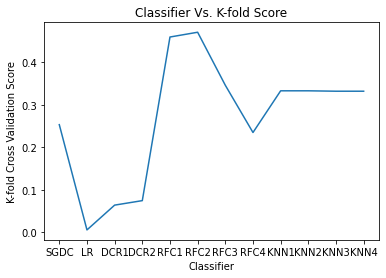

In [32]:
# Graph the average validation scores
plt.xlabel("Classifier")
plt.ylabel("K-fold Cross Validation Score")
plt.title("Classifier Vs. K-fold Score")
x_data = ["SGDC", "LR", "DCR1", "DCR2", "RFC1", "RFC2", "RFC3", "RFC4", "KNN1", "KNN2", "KNN3", "KNN4"]
y_data = [cv_sgdc_avg, cv_LR_avg, cv_DCR1_avg, cv_DCR2_avg, cv_RFC1_avg, cv_RFC2_avg, cv_RFC3_avg, cv_RFC4_avg, cv_KNN1_avg, cv_KNN2_avg, cv_KNN3_avg, cv_KNN4_avg]
plt.plot(x_data, y_data)

# Stratified K-Fold Cross Validation

In [41]:
# Stratified k-fold
skf = StratifiedKFold(n_splits=3)

# Get the stratified cross validation score for every model
scv_sgdc = cross_val_score(sgdc, batchC["all"]["X"], batchC["all"]["y"], cv=skf)

scv_LR = cross_val_score(LR, batchC["all"]["X"], batchC["all"]["y"], cv=skf)

scv_DCR1 = cross_val_score(DCR1, batchC["all"]["X"], batchC["all"]["y"], cv=skf)
scv_DCR2 = cross_val_score(DCR2, batchC["all"]["X"], batchC["all"]["y"], cv=skf)

scv_RFC1 = cross_val_score(RFC1, batchC["all"]["X"], batchC["all"]["y"], cv=skf)
scv_RFC2 = cross_val_score(RFC2, batchC["all"]["X"], batchC["all"]["y"], cv=skf)
scv_RFC3 = cross_val_score(RFC3, batchC["all"]["X"], batchC["all"]["y"], cv=skf)
scv_RFC4 = cross_val_score(RFC4, batchC["all"]["X"], batchC["all"]["y"], cv=skf)

scv_KNN1 = cross_val_score(KNN1, batchC["all"]["X"], batchC["all"]["y"], cv=skf)
scv_KNN2 = cross_val_score(KNN2, batchC["all"]["X"], batchC["all"]["y"], cv=skf)
scv_KNN3 = cross_val_score(KNN3, batchC["all"]["X"], batchC["all"]["y"], cv=skf)
scv_KNN4 = cross_val_score(KNN4, batchC["all"]["X"], batchC["all"]["y"], cv=skf)

In [42]:
# Get the average scores
scv_sgdc_avg = np.average(scv_sgdc)

scv_LR_avg = np.average(scv_LR)

scv_DCR1_avg = np.average(scv_DCR1)
scv_DCR2_avg = np.average(scv_DCR2)

scv_RFC1_avg = np.average(scv_RFC1)
scv_RFC2_avg = np.average(scv_RFC2)
scv_RFC3_avg = np.average(scv_RFC3)
scv_RFC4_avg = np.average(scv_RFC4)

scv_KNN1_avg = np.average(scv_KNN1)
scv_KNN2_avg = np.average(scv_KNN2)
scv_KNN3_avg = np.average(scv_KNN3)
scv_KNN4_avg = np.average(scv_KNN4)

In [43]:
# Print the scores
print("Stochastic Gradient Descent:")
print(f"  SGDC Scores: {scv_sgdc}")
print(f"  SGDC Avg Score: {scv_sgdc_avg}")
print()

print("Linear Regression:")
print(f"  Linear Regression Scores: {scv_LR}")
print(f"  Linear Regression Avg Score: {scv_LR_avg}")
print()

print("Decision Tree Regressor:")
print(f"  DCR1 Scores: {scv_DCR1}")
print(f"  DCR1 Avg Score: {scv_DCR1_avg}")
print(f"  DCR2 Scores: {scv_DCR2}")
print(f"  DCR2 Avg Score: {scv_DCR2_avg}")
print()

print("Random Forest Classifier:")
print(f"  RFC1 Scores: {scv_RFC1}")
print(f"  RFC1 Avg Score: {scv_RFC1_avg}")
print(f"  RFC2 Scores: {scv_RFC2}")
print(f"  RFC2 Avg Score: {scv_RFC2_avg}")
print(f"  RFC3 Scores: {scv_RFC3}")
print(f"  RFC3 Avg Score: {scv_RFC3_avg}")
print(f"  RFC4 Scores: {scv_RFC4}")
print(f"  RFC4 Avg Score: {scv_RFC4_avg}")
print()

print("KNeighbors Classifier:")
print(f"  KNN1 Scores: {scv_KNN1}")
print(f"  KNN1 Avg Score: {scv_KNN1_avg}")
print(f"  KNN2 Scores: {scv_KNN2}")
print(f"  KNN2 Avg Score: {scv_KNN2_avg}")
print(f"  KNN3 Scores: {scv_KNN3}")
print(f"  KNN3 Avg Score: {scv_KNN3_avg}")
print(f"  KNN4 Scores: {scv_KNN4}")
print(f"  KNN4 Avg Score: {scv_KNN4_avg}")
print()

Stochastic Gradient Descent:
  SGDC Scores: [0.18445 0.26815 0.27365]
  SGDC Avg Score: 0.24208333333333334

Linear Regression:
  Linear Regression Scores: [0.00179788 0.00701177 0.00604261]
  Linear Regression Avg Score: 0.00495075672291434

Decision Tree Regressor:
  DCR1 Scores: [0.06519377 0.05833587 0.06556683]
  DCR1 Avg Score: 0.06303215848701711
  DCR2 Scores: [0.07578391 0.06957511 0.08033266]
  DCR2 Avg Score: 0.07523055877651645

Random Forest Classifier:
  RFC1 Scores: [0.45565 0.45485 0.46   ]
  RFC1 Avg Score: 0.45683333333333337
  RFC2 Scores: [0.47045 0.46875 0.47405]
  RFC2 Avg Score: 0.47108333333333335
  RFC3 Scores: [0.3507  0.3432  0.34945]
  RFC3 Avg Score: 0.34778333333333333
  RFC4 Scores: [0.22615 0.22735 0.23655]
  RFC4 Avg Score: 0.23001666666666667

KNeighbors Classifier:
  KNN1 Scores: [0.3336  0.3331  0.33265]
  KNN1 Avg Score: 0.33311666666666667
  KNN2 Scores: [0.3336  0.3331  0.33265]
  KNN2 Avg Score: 0.33311666666666667
  KNN3 Scores: [0.3314  0.3334 

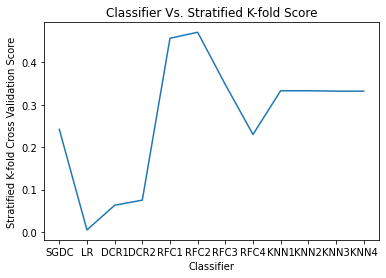

In [44]:
# Graph the average validation scores
plt.xlabel("Classifier")
plt.ylabel("Stratified K-fold Cross Validation Score")
plt.title("Classifier Vs. Stratified K-fold Score")
x_data = ["SGDC", "LR", "DCR1", "DCR2", "RFC1", "RFC2", "RFC3", "RFC4", "KNN1", "KNN2", "KNN3", "KNN4"]
y_data = [scv_sgdc_avg, scv_LR_avg, scv_DCR1_avg, scv_DCR2_avg, scv_RFC1_avg, scv_RFC2_avg, scv_RFC3_avg, scv_RFC4_avg, scv_KNN1_avg, scv_KNN2_avg, scv_KNN3_avg, scv_KNN4_avg]
plt.plot(x_data, y_data)

### Mean Squared Error

In [29]:
from sklearn.metrics import mean_squared_error
predictions = LR.predict(batchC["train"]["X"])
lin_mse = mean_squared_error(batchC["train"]["y"], predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

2.647726488393076

### Confusion Matrix

In [37]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(RFC1, batchC["train"]["X"], batchC["train"]["y"], cv=3)

In [38]:
from sklearn.metrics import confusion_matrix
confusion_matrix(batchC["train"]["y"], y_train_pred)

array([[2625,  261,  265,  137,  148,  130,  126,  175,  818,  315],
       [ 163, 2619,   76,  191,  130,  159,  190,  181,  321,  970],
       [ 511,  209, 1499,  341,  794,  348,  670,  298,  170,  160],
       [ 248,  239,  385, 1368,  396,  920,  715,  292,  125,  312],
       [ 298,  128,  716,  257, 1931,  262,  702,  409,  130,  167],
       [ 172,  205,  448,  804,  419, 1833,  457,  352,  109,  201],
       [  97,  182,  406,  396,  620,  319, 2649,  147,   42,  142],
       [ 217,  201,  273,  315,  570,  379,  280, 2209,  116,  440],
       [ 499,  429,   90,  149,  105,  181,   68,   85, 2974,  420],
       [ 204,  849,   75,  149,   87,  135,  165,  190,  377, 2769]])

### ROC Curve

In [89]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(batchC["train"]["y"], y_train_pred, pos_label=1)

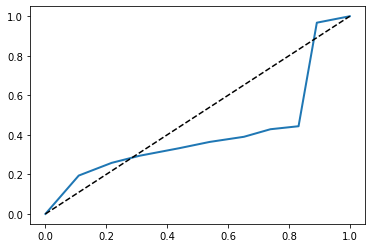

In [94]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    [...] # Add axis labels and grid

plot_roc_curve(fpr, tpr)
plt.show()


### GridSearchVC

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#param_grid = [{'max_depth': list(range(10, 15)), 'max_features': list(range(0,14))}]
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(batchC["train"]["X"], batchC["train"]["y"])

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             scoring='neg_mean_squared_error')

In [29]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [30]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

In [32]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"])::    print(np.sqrt(-mean_score), params)

3.0913409531931104 {'max_features': 2, 'n_estimators': 3}
2.7610027164057627 {'max_features': 2, 'n_estimators': 10}
2.675920464687494 {'max_features': 2, 'n_estimators': 30}
3.064511924162367 {'max_features': 4, 'n_estimators': 3}
2.7521240161010185 {'max_features': 4, 'n_estimators': 10}
2.65751621297448 {'max_features': 4, 'n_estimators': 30}
3.0478290999040976 {'max_features': 6, 'n_estimators': 3}
2.749205012362665 {'max_features': 6, 'n_estimators': 10}
2.650693397752537 {'max_features': 6, 'n_estimators': 30}
3.0332216096641096 {'max_features': 8, 'n_estimators': 3}
2.731750903724569 {'max_features': 8, 'n_estimators': 10}
2.6431117687722216 {'max_features': 8, 'n_estimators': 30}
3.0777452064060724 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
2.7432875168308555 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
3.0434738923364093 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
2.7428721443042146 {'bootstrap': False, 'max_features': 3, 'n_estima